In [1]:
import chess
import chess.engine
import pipe
import torch
from tqdm import tqdm

In [2]:
# Path to your stockfish binary
STOCKFISH_PATH = "/home/noor-zalouk/ME/NLP/Chess/stockfish/stockfish-ubuntu-x86-64-avx2"

device = "cpu"

model = pipe.arch.ChessMoveClassifier(pipe.config, device)
state_dict = torch.load('./chess_model.pth')
model.load_state_dict(state_dict)

best_configs = [(2, 6), (4, 4), (9, 3)] # (k, depth)

In [3]:
board = chess.Board("8/8/8/8/8/8/8/k7 w - - 0 1")
board.is_game_over()

True

In [4]:
# --- Match loop ---
def play_matches(depth, k, n_games=50, opponent_level=5):
    results = []
    with chess.engine.SimpleEngine.popen_uci(STOCKFISH_PATH) as sf:
        # Limit Stockfish strength (so it's not crushing you always)
        sf.configure({"Skill Level": opponent_level})

        loop = tqdm(range(n_games), desc=f"Playing {n_games} games with depth={depth}, k={k}")
        for g in loop:
            board = chess.Board()
            while not board.is_game_over():
                if board.turn:
                    # Your engine plays White
                    move, _, _ = pipe.choose_move(board, model, device, depth=depth, k=k)
                    move = move[0]
                else:
                    # Stockfish move
                    result = sf.play(board, chess.engine.Limit(depth=8))
                    move = result.move

                board.push(move)

            # Collect result
            outcome = board.result()
            if outcome == "1-0":
                results.append(1)      # win
            elif outcome == "0-1":
                results.append(0)      # loss
            else:
                results.append(0.5)    # draw

    return results

In [5]:
outcomes = {}
for k, depth in best_configs:
    outcomes[f"Depth={depth}__K={k}"] = play_matches(depth, k, n_games=50, opponent_level=5)

Playing 50 games with depth=3, k=9: 100%|██████████| 50/50 [52:14<00:00, 62.70s/it] 


In [9]:
import pickle
with open("results.pkl", "wb") as f:
    pickle.dump(outcomes, f)

In [ ]:
import pandas as pd

df = pd.DataFrame(outcomes)

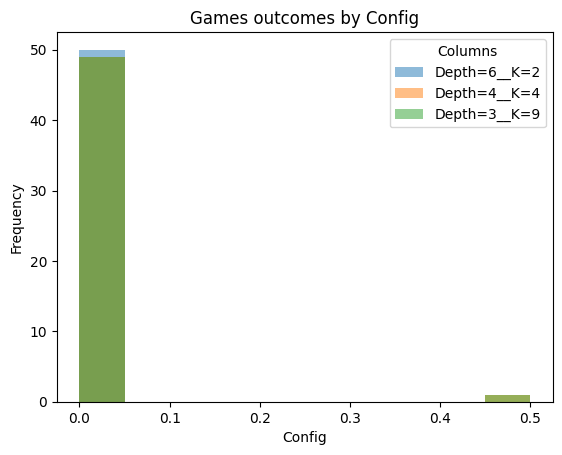

In [11]:
import matplotlib.pyplot as plt

df.plot.hist(bins=10, alpha=0.5)
plt.title('Games outcomes by Config')
plt.xlabel('Config')
plt.ylabel('Frequency')
plt.legend(title='Columns')
plt.show()

In [16]:
import math

def expected_score(rating_a, rating_b):
    return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))

def estimate_elo(score, opponent_elo):
    # Solve for your rating based on expected score
    if score in [0, 1]:
        return None  # Can't solve if always loses or always wins
    return opponent_elo - 400 * math.log10(1/score - 1)

In [18]:
estimate_elo(df['Depth=4__K=4'].mean(), 2000)  # Example with opponent elo of 1500

1201.7459221609802